# Proximal Policy Optimization Agent Using PyTorch
This notebook contains an implementation of PPO algorithm using PyTorch

The algorithm is then tested using OpenAI's cartpole environment

This notebook is based on this great [repo](https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/PolicyGradient/PPO) and this great [notebook](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb) 



### Managing 

In [8]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [9]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [10]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
    
    def generate_batches (self):
        n_states = len(self.states)
        indices = np.arange(0, n_states)
        batch_start = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return np.array(self.states),\
               np.array(self.actions),\
               np.array(self.log_probs),\
               np.array(self.values),\
               np.array(self.rewards),\
               np.array(self.dones),\
               batches
    def store_memory(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
        
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []
        

In [11]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dim, alpha,
                fc1_dim=256, fc2_dim=256, check_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()
        self.checkpoint_file = os.path.join(check_dir, 'actor_ppo')
        
        self.actor = nn.Sequential(
        nn.Linear(*input_dim, fc1_dim),
        nn.ReLU(),
        nn.Linear(fc1_dim, fc2_dim),
        nn.ReLU(),
        nn.Linear(fc2_dim, n_actions),
        nn.Softmax(dim=-1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [12]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dim, alpha,
                fc1_dim=256, fc2_dim=256, check_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()
        self.checkpoint_file = os.path.join(check_dir, 'critic_ppo')
        self.critic = nn.Sequential(
        nn.Linear(*input_dim, fc1_dim),
        nn.ReLU(),
        nn.Linear(fc1_dim, fc2_dim),
        nn.ReLU(),
        nn.Linear(fc2_dim, 1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        value = self.critic(state)
        
        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [13]:
class PPOAgent:
    def __init__(self, n_actions, input_dim, gamma=0.99, lamda=0.95, alpha=0.0003,
                clip=0.2, batch_size=64, n_epochs=10):
        self.gamma=gamma
        self.lamda=lamda
        self.clip=clip
        self.n_epochs=n_epochs
        
        self.actor = ActorNetwork(n_actions, input_dim, alpha)
        self.critic = CriticNetwork(input_dim, alpha)
        self.memory = PPOMemory(batch_size)
        
    def remember(self, state, action, log_prob, value, reward, done):
        self.memory.store_memory(state, action, log_prob, value, reward, done)

    def save_models(self):
        print('-----Saving Models-----')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('-----Loading Models-----')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        action = dist.sample()
        value = self.critic(state)

        log_prob = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return log_prob, action, value

    def learn(self):
        for _ in range(self.n_epochs):
            states_arr, actions_arr, old_probs_arr, values, rewards,\
            dones, batches = self.memory.generate_batches()

            advantages = np.zeros_like(rewards, dtype=np.float32)
            for t in range(len(rewards)-1):
                discount = 1
                a_t = 0
                for s in range(t, len(rewards)-1):
                    a_t += discount*(rewards[s] + self.gamma*values[s+1]*\
                        (1-int(dones[s])) - values[s])
                    discount *= self.gamma * self.lamda
                advantages[t] = a_t
            advantages = T.tensor(advantages).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)

            for batch in batches:
                states = T.tensor(states_arr[batch], dtype=T.float).to(self.actor.device)
                actions = T.tensor(actions_arr[batch]).to(self.actor.device)
                old_probs = T.tensor(old_probs_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_values = self.critic(states)
                critic_values = T.squeeze(critic_values)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp()/old_probs.exp()
                wighted_probs = prob_ratio*advantages[batch]
                clipped_wighted_probs = T.clamp(prob_ratio, 1-self.clip, 1+self.clip) * advantages[batch]
                actor_loss = -T.min(wighted_probs, clipped_wighted_probs).mean()

                critic_loss = (((advantages[batch]+values[batch]) - critic_values)**2).mean()

                total_loss = actor_loss + 0.5*critic_loss

                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [23]:
import gym

env = gym.make('CartPole-v0')
N=20
batch_size = 5
n_epochs = 4
clip = 0.15
n_games = 300

agent = PPOAgent(n_actions=env.action_space.n, 
                 input_dim=env.observation_space.shape,
                batch_size = batch_size, n_epochs=n_epochs, clip=clip)

learn_iters = 0
best_score = env.reward_range[0]
score_history = []
n_steps = 0
avg_score = 0
for _ in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        prob, action, value = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, value, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters+=1
        observation = observation_
            
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
      best_score = avg_score
      agent.save_models()
    
    print('episode', _, 'score %.1f' % score, 'avg score %.1f' % avg_score,
        'time_steps', n_steps, 'learning_steps', learn_iters)

-----Saving Models-----
episode 0 score 14.0 avg score 14.0 time_steps 14 learning_steps 0
-----Saving Models-----
episode 1 score 16.0 avg score 15.0 time_steps 30 learning_steps 1
-----Saving Models-----
episode 2 score 16.0 avg score 15.3 time_steps 46 learning_steps 2
-----Saving Models-----
episode 3 score 20.0 avg score 16.5 time_steps 66 learning_steps 3
-----Saving Models-----
episode 4 score 19.0 avg score 17.0 time_steps 85 learning_steps 4
episode 5 score 15.0 avg score 16.7 time_steps 100 learning_steps 5
episode 6 score 15.0 avg score 16.4 time_steps 115 learning_steps 5
episode 7 score 13.0 avg score 16.0 time_steps 128 learning_steps 6
episode 8 score 17.0 avg score 16.1 time_steps 145 learning_steps 7
episode 9 score 15.0 avg score 16.0 time_steps 160 learning_steps 8
episode 10 score 11.0 avg score 15.5 time_steps 171 learning_steps 8
-----Saving Models-----
episode 11 score 55.0 avg score 18.8 time_steps 226 learning_steps 11
-----Saving Models-----
episode 12 score 2

In [24]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [25]:
from IPython import display as ipythondisplay
from PIL import Image

def render_episode(env, model, max_steps): 

  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = env.reset()
  for i in range(1, max_steps + 1):
    prob, action_, val = model.choose_action(state)

    state, _, done, _ = env.step(action)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images

In [26]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# Save GIF image
images = render_episode(env, agent, 100)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


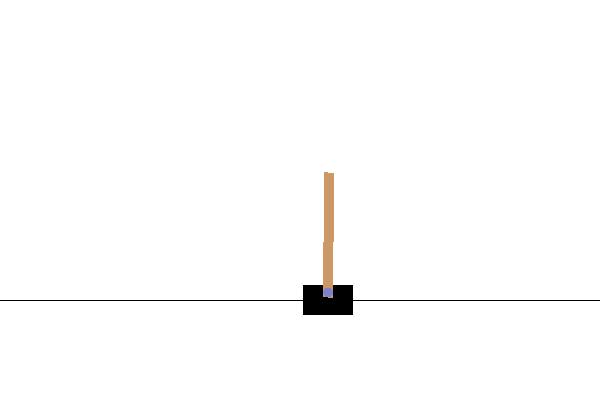

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)